In [1]:
import pandas as pd

df_script = pd.read_csv('../data/thesimpsons/simpsons_script_lines.csv', low_memory=False)
df_episodes = pd.read_csv('../data/thesimpsons/simpsons_episodes.csv', low_memory=False)
df_characters = pd.read_csv('../data/thesimpsons/simpsons_characters.csv', low_memory=False)
df_locations = pd.read_csv('../data/thesimpsons/simpsons_locations.csv', low_memory=False)

df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)


assert data.shape[0] == df_script.shape[0]

In [ ]:
import tiktoken

# Função para estimar número de tokens
def estimar_tokens(texto):
    encoder = tiktoken.get_encoding("cl100k_base") 
    tokens = encoder.encode(texto)
    return tokens

# Adicionando coluna de tokens ao DataFrame
data['tokens'] = data['spoken_words'].fillna('').apply(estimar_tokens)

In [49]:
data.to_csv("simpson_show_df.csv")

In [23]:
# Tokens por episódio
tokens_por_episodio = data.groupby('episode_id')['tokens'].sum().reset_index()

# Tokens por temporada
tokens_por_temporada = data.groupby('episode_season')['tokens'].sum().reset_index()


In [25]:
print(tokens_por_episodio['tokens'].apply(type).unique())


[<class 'list'>]


In [26]:
import numpy as np

# Garantir que todos os valores sejam numéricos
tokens_por_episodio['tokens'] = tokens_por_episodio['tokens'].apply(
    lambda x: sum(x) if isinstance(x, list) else x
)
tokens_por_episodio['tokens'] = pd.to_numeric(tokens_por_episodio['tokens'], errors='coerce')

tokens_por_temporada['tokens'] = tokens_por_temporada['tokens'].apply(
    lambda x: sum(x) if isinstance(x, list) else x
)
tokens_por_temporada['tokens'] = pd.to_numeric(tokens_por_temporada['tokens'], errors='coerce')


In [ ]:
# Média de tokens
media_tokens_episodio = tokens_por_episodio['tokens'].mean()
media_tokens_temporada = tokens_por_temporada['tokens'].mean()

# Episódio e temporada com mais tokens
episodio_mais_tokens = tokens_por_episodio.loc[tokens_por_episodio['tokens'].idxmax()]
temporada_mais_tokens = tokens_por_temporada.loc[tokens_por_temporada['tokens'].idxmax()]

# Formatar os resultados
media_tokens_episodio = f"{media_tokens_episodio:,.2f}"
media_tokens_temporada = f"{media_tokens_temporada:,.2f}"
episodio_mais_tokens_valor = f"{episodio_mais_tokens['tokens']:,.0f}"
temporada_mais_tokens_valor = f"{temporada_mais_tokens['tokens']:,.0f}"

print(f"Média de tokens por episódio: {media_tokens_episodio}")
print(f"Média de tokens por temporada: {media_tokens_temporada}")
print(f"Episódio com mais tokens: {episodio_mais_tokens['episode_id']} com {episodio_mais_tokens_valor} tokens")
print(f"Temporada com mais tokens: {temporada_mais_tokens['episode_season']} com {temporada_mais_tokens_valor} tokens")


Média de tokens por episódio: 24,703,486.93
Média de tokens por temporada: 535,875,639.46
Episódio com mais tokens: 465 com 39,571,963 tokens
Temporada com mais tokens: 7 com 682,490,154 tokens


In [31]:
cols = ['episode_id', 'episode_season','episode_original_air_date', 'episode_imdb_rating', 
        'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']
episode_stats = data[cols].drop_duplicates()

episode_stats.to_csv('series_data.csv', sep=';', index=None)

In [ ]:
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
import os 
from dotenv import load_dotenv
import json

prompt_start = f"""
You are a data scientist high specialized in analysing entertainment content. You are working on the show series
"The Simpsons", investigating patterns in the series series_data. 
How can we evaluate the relationship between episode ratings ('episode_imdb_rating', 'episode_imdb_votes')
and audiences ('episode_us_viewers_in_millions', 'episode_views') in series_data.csv, considering it a CSV file
splitted by ';' with columns:

- episode_id: episode unique identifier
- episode_season: episode season number
- episode_original_air_date: date that the episode was first exhibited
- episode_imdb_rating: episode with the IMDB rating 
- episode_imdb_votes: episode with the number of voters
- episode_us_viewers_in_millions: number of episode viewers (in millions)
- episode_views: total number of episode views.

Generate a list of 5 analyses that can be implemented given the available series_data, as a JSON file:
{[
    {'Name':'analysis name',
     'Objective': 'what we need to analyze',
     'Method': 'how we analyze it'
    }
]
}
"""


genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_start)
analysis = json.loads(response.text.replace("```json\n",'').replace("\n```",''))
analysis

[{'Name': 'Correlation Analysis of Ratings and Viewership',
  'Objective': 'To determine the correlation between episode IMDB ratings and both US viewership and total views.',
  'Method': "Calculate Pearson correlation coefficients between 'episode_imdb_rating' and 'episode_us_viewers_in_millions', and between 'episode_imdb_rating' and 'episode_views'.  Visualize the correlations using scatter plots to identify potential linear relationships and outliers.  Consider also Spearman's rank correlation if the data is not normally distributed."},
 {'Name': 'Regression Analysis Predicting Viewership from Ratings',
  'Objective': 'To build a model that predicts US viewership and total views based on IMDB ratings and potentially other factors like season.',
  'Method': 'Employ linear regression or other suitable regression models (e.g., polynomial regression if the relationship is non-linear).  Evaluate model performance using metrics like R-squared, RMSE, and MAE.  Feature engineering might in

In [ ]:
prompt_analysis = f"""
You are a data scientist high specialized in analysing entertainment content. You are working on the show series
"The Simpsons", investigating patterns in the series series_data. 
How can we evaluate the relationship between episode ratings ('episode_imdb_rating', 'episode_imdb_votes')
and audiences ('episode_us_viewers_in_millions', 'episode_views') in "series_data.csv", considering it a CSV file
splitted by ';' with columns:

- episode_id: episode unique identifier
- episode_season: episode season number
- episode_original_air_date: date that the episode was first exhibited
- episode_imdb_rating: episode with the IMDB rating 
- episode_imdb_votes: episode with the number of voters
- episode_us_viewers_in_millions: number of episode viewers (in millions)
- episode_views: total number of episode views.

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[0]}
"""


genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analysis)
print(response.text)

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# Load the data
series_data = pd.read_csv("series_data.csv", sep=";")

# Handle missing values (replace with mean for simplicity)

for col in ['episode_imdb_rating', 'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']:
    series_data[col] = series_data[col].fillna(series_data[col].mean())


# Calculate Pearson correlation coefficients
correlation_matrix = series_data[['episode_imdb_rating', 'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']].corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Ratings and Viewership')
plt.show()

# Perform regression analysis
# Model 1: IMDB rating predicting US viewers
model1 = smf.ols('episode_us_viewers_in_millions ~ episode_imdb_rating', data=series_d

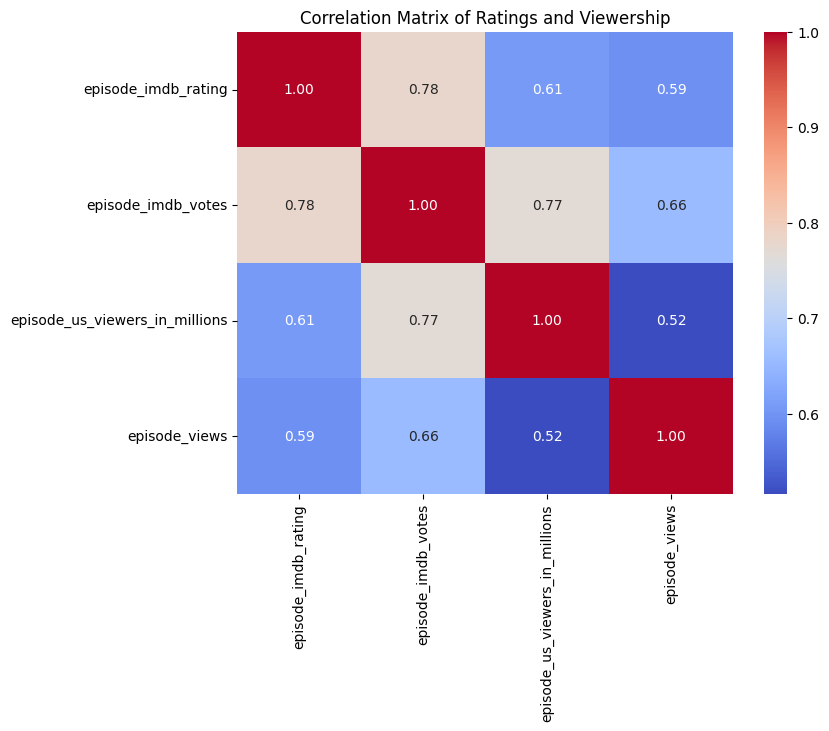

                                  OLS Regression Results                                  
Dep. Variable:     episode_us_viewers_in_millions   R-squared:                       0.590
Model:                                        OLS   Adj. R-squared:                  0.588
Method:                             Least Squares   F-statistic:                     268.9
Date:                            Thu, 28 Nov 2024   Prob (F-statistic):          4.53e-108
Time:                                    01:46:08   Log-Likelihood:                -1584.8
No. Observations:                             564   AIC:                             3178.
Df Residuals:                                 560   BIC:                             3195.
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--

In [38]:
import statsmodels
import seaborn as sns
analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)

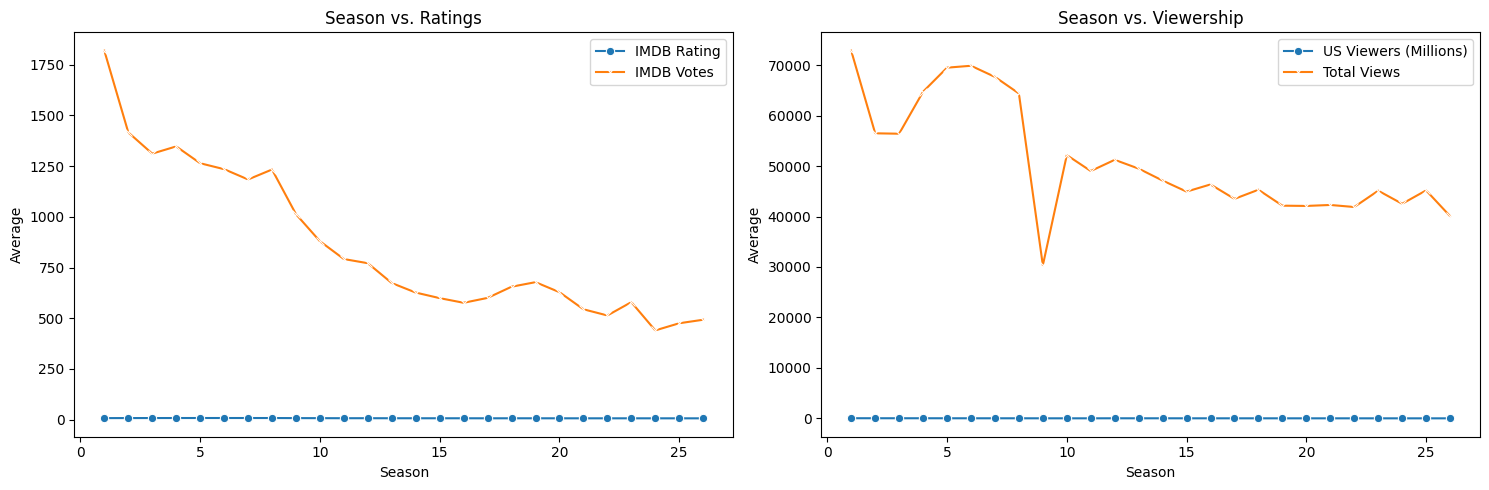

In [ ]:
prompt_analysis = f"""
You are a data scientist high specialized in analysing entertainment content. You are working on the show series
"The Simpsons", investigating patterns in the series series_data. 
How can we evaluate the relationship between episode ratings ('episode_imdb_rating', 'episode_imdb_votes')
and audiences ('episode_us_viewers_in_millions', 'episode_views') in "series_data.csv", considering it a CSV file
splitted by ';' with columns:

- episode_id: episode unique identifier
- episode_season: episode season number
- episode_original_air_date: date that the episode was first exhibited
- episode_imdb_rating: episode with the IMDB rating 
- episode_imdb_votes: episode with the number of voters
- episode_us_viewers_in_millions: number of episode viewers (in millions)
- episode_views: total number of episode views.

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[1]}
"""

genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analysis)

analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)

In [44]:
print(response.text)

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
series_data = pd.read_csv('series_data.csv', sep=';')

# Group data by season and calculate mean values
season_stats = series_data.groupby('episode_season')[['episode_imdb_rating', 'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']].mean()

# Create line plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=season_stats.index, y=season_stats['episode_imdb_rating'], marker='o', label='IMDB Rating')
sns.lineplot(x=season_stats.index, y=season_stats['episode_imdb_votes'], marker='x', label='IMDB Votes')
plt.title('Season vs. Ratings')
plt.xlabel('Season')
plt.ylabel('Average')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x=season_stats.index, y=season_stats['episode_us_viewers_in_millions'], marker='o', label='US Viewers (Millions)')
sns.lineplot(x=season_stats.index, y=season_stats['episode_views'], marker='x', label='Total Views')
plt.title('S

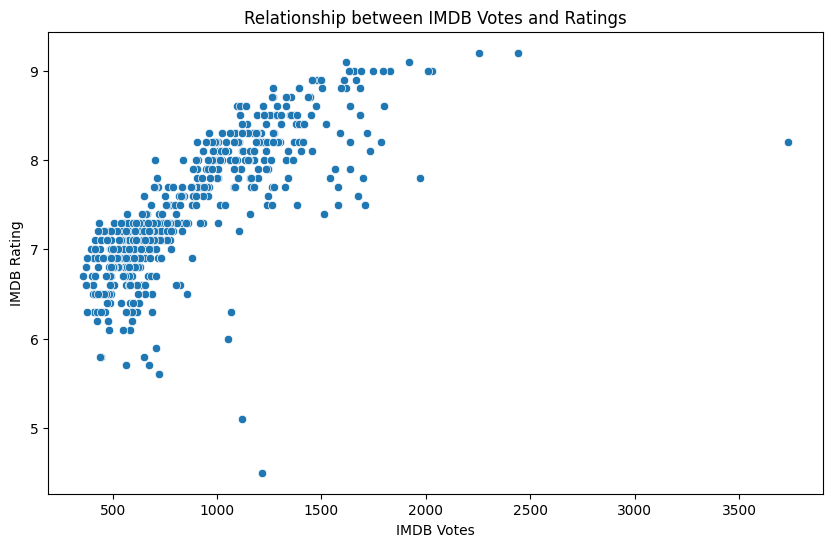

Correlation coefficient: 0.78
P-value: 0.000

High Vote Outliers:
     episode_id  episode_imdb_votes  episode_imdb_rating
52           71              2028.0                  9.0
64           83              2010.0                  9.0
137         155              2439.0                  9.2
156         176              2256.0                  9.2
539           1              3734.0                  8.2
542           2              1973.0                  7.8

Low Vote Outliers:
     episode_id  episode_imdb_votes  episode_imdb_rating
422         566               360.0                  6.7
496         527               371.0                  6.8
497         530               396.0                  7.0
530         565               377.0                  6.3
531         567               372.0                  6.6
532         568               377.0                  6.9


In [ ]:
prompt_analysis = f"""
You are a data scientist high specialized in analysing entertainment content. You are working on the show series
"The Simpsons", investigating patterns in the series series_data. 
How can we evaluate the relationship between episode ratings ('episode_imdb_rating', 'episode_imdb_votes')
and audiences ('episode_us_viewers_in_millions', 'episode_views') in "series_data.csv", considering it a CSV file
splitted by ';' with columns:

- episode_id: episode unique identifier
- episode_season: episode season number
- episode_original_air_date: date that the episode was first exhibited
- episode_imdb_rating: episode with the IMDB rating 
- episode_imdb_votes: episode with the number of voters
- episode_us_viewers_in_millions: number of episode viewers (in millions)
- episode_views: total number of episode views.

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[2]}
"""


genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analysis)


analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)

In [42]:
print(response.text)

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load the data
series_data = pd.read_csv('series_data.csv', sep=';')

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='episode_imdb_votes', y='episode_imdb_rating', data=series_data)
plt.title('Relationship between IMDB Votes and Ratings')
plt.xlabel('IMDB Votes')
plt.ylabel('IMDB Rating')
plt.show()

# Calculate the correlation coefficient
correlation, p_value = pearsonr(series_data['episode_imdb_votes'], series_data['episode_imdb_rating'])
print(f"Correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

# Investigate outliers
high_vote_outliers = series_data[series_data['episode_imdb_votes'] > series_data['episode_imdb_votes'].quantile(0.99)]
low_vote_outliers = series_data[series_data['episode_imdb_votes'] < series_data['episode_imdb_votes'].quantile(0.01)]

print("\nHigh Vote Outliers:")
print(high_vote_outliers[['episode